# Cloud Optimized Geotiff (COG) Overview Resampling

When making Cloud-Optimized GeoTIFFs (COGs), you can select the resampling method to generate the overviews. Different types of data (e.g., nominal, ordinal, discrete, continuous) can drastically change appearance when more zoomed out based on the chosen method. This is most important when using software that renders from overviews (e.g., QGIS, ArcGIS), particularly web tilers like [Titiler](https://developmentseed.org/titiler/). 

Also, when using a tiling service on a high-resolution dataset, you will often have many tiles of source data. The idea behind this notebook is that before you generate all your final output data, as COGs, or if you need to rebuild your overviews, you should first test on some representative samples. After testing, you'll know which method to use in your data pipeline.

This notebook loops over the overview resampling methods available in [GDAL](https://gdal.org/) applying it to the same sample tile to compare how the dataset will appear when zoomed out from the full resolution. 

> Note: GDAL 3.2 specifically added the ability to specify the resampling method for the overviews. GDAL 3.3 added a couple of new resampling ways. 

## Setup Environment

* Requires `gdal >= 3.2` for Overview Resampling to work
* RMS resampling was added in GDAL 3.3


The packages needed for this notebook can be installed with `conda` or `mamba`. Using the [`environment.yml` from this folder](./environment.yml) run:

```bash
conda env create -f environment.yml
```

Or:

```bash
mamba env create -f environment.yml
```

Or you can install the packages you need manually:

```
mamba create -q -y -n coguide-cog -c conda-forge 'gdal>=3.3' 'rasterio>=1.3.3' 'rio-cogeo=3.5.0' ipykernel matplotlib earthaccess
```

Then, you may activate and select the kernel in the notebook (running in Jupyter):

```bash
conda activate coguide-cog
```

This notebook has been tested to work with the listed Conda environment.

Remember to switch your notebook kernel if you made a new env; you may need to activate the new env first.

## Setup the code

First, we should verify our GDAL version:

In [1]:
!gdalinfo --version

GDAL 3.7.3, released 2023/10/30


In [2]:
import os

import earthaccess
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.session import AWSSession
from rasterio.plot import show
from rio_cogeo import cog_translate, cog_profiles


/home/ochotona/anaconda3/envs/coguide-cog/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Boreal Biomass Tiled Data

The example data comes from the [Aboveground Biomass Density for High Latitude Forests from ICESat-2, 2020](https://cmr.earthdata.nasa.gov/search/concepts/C2756302505-ORNL_CLOUD.html)

To access and integrate NASA Earth data into your Jupyter Notebook, you can create an account by visiting [NASA's Earthdata Login page](https://urs.earthdata.nasa.gov/users/new). This will enable you to register for an account and retrieve the datasets used in the notebook.

You can see the whole mosaic of all the data on the [MAAP Biomass dashboard](https://www.earthdata.nasa.gov/maap-biomass/products/icesat2_boreal?map=-124.0135%2C63.1543%2C2.62&layers=icesat2_boreal_biomass_reduced%2Cicesat2_boreal_biomass&lState=)

For this example, we will pull a single 3000x3000 pixel tile that is part of the larger dataset of more than 3500 tiles.

We must retrieve a NASA Earth data session for downloading data:


In [3]:
earthaccess.login(strategy="interactive")

We can now query NASA CMR to retrieve a download URL: 

In [4]:
short_name = 'Boreal_AGB_Density_ICESat2_2186'
item = 'Boreal_AGB_Density_ICESat2.boreal_agb_202302061675666220_3741.tif'

item_results = earthaccess.search_data(
    short_name=short_name,
    cloud_hosted=True,
    granule_name=item
    
)

Granules found: 1


Finally, we can download the COG for local use:

In [5]:
test_data_dir = "./test_data"
os.makedirs(test_data_dir, exist_ok=True)

sample_files = earthaccess.download(item_results, test_data_dir)
tile = f"{sample_files[0]}"

 Getting 1 granules, approx download size: 0.09 GB


QUEUEING TASKS | : 100%|██████████| 2/2 [00:00<00:00, 1733.18it/s]


File boreal_agb_202302061675666220_3741.tif already downloaded
File boreal_agb_202302061675666220_3741.tif.sha256 already downloaded


PROCESSING TASKS | : 100%|██████████| 2/2 [00:00<00:00, 15621.24it/s]
COLLECTING RESULTS | : 100%|██████████| 2/2 [00:00<00:00, 34239.22it/s]


> Note: We downloaded the file because, it's small (less than 100 MB), and we're going to use the whole file several times.

Using rio cogeo, we can investigate if the file has tiles and what resampling was used:


In [6]:
!rio cogeo info {tile}

Driver: GTiff
File: /home/ochotona/code/devseed/cloud-optimized-geospatial-formats-guide/cloud-optimized-geotiffs/test_data/boreal_agb_202302061675666220_3741.tif
COG: True
Compression: LZW
ColorSpace: None

Profile
    Width:            3000
    Height:           3000
    Bands:            2
    Tiled:            True
    Dtype:            float32
    NoData:           -9999.0
    Alpha Band:       False
    Internal Mask:    False
    Interleave:       PIXEL
    ColorMap:         False
    ColorInterp:      ('gray', 'undefined')
    Scales:           (1.0, 1.0)
    Offsets:          (0.0, 0.0)

Geo
    Crs:              PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["stan

## Generate Overviews

Now, let's generate overviews with each resampling method possible in GDAL.

In [7]:
def generate_overview(src_path: str, out_dir: str, resample_method: str) -> str:
    ''' 
    Create a copy of original GeoTiff as COG with different overview resampling method
    src_path = the original GeotTiff
    out_dir = the folder for outputs (can differ from src)
    method = the resampling method
    return = the path to the new file
    '''
    #make sure the output folder exists
    os.makedirs(out_dir, exist_ok=True)
    dst_path = src_path.replace(".tif", f"_{resample_method}.tif")
    dst_path = f"{out_dir}/{os.path.basename(dst_path)}"
    
    # Using multiple CPUS
    # Using blocksize 512 per recommendations
    config = {"GDAL_NUM_THREADS": "ALL_CPUS", "GDAL_TIFF_OVR_BLOCKSIZE": "512"} 
    output_profile = cog_profiles.get("deflate")
    output_profile.update({"blockxsize": "512", "blockysize": "512"})
    
    print(f"Creating COG using '{resample_method}' method: {dst_path}")
    cog_translate(
        src_path,
        dst_path,
        output_profile,
        config=config,
        overview_resampling=resample_method,
        forward_band_tags=True,
        use_cog_driver=True,
        quiet=True,
    )

    return dst_path

Now, we can make a list of the resampling methods offered by GDAL. Some resampling methods aren't appropriate for the data, so we are doing to drop those from the list. You can see descriptions at https://gdal.org/programs/gdalwarp.html#cmdoption-gdalwarp-r 

In [1]:
# Make a list of resampling methods that GDAL 3.4+ allows

from rasterio.enums import Resampling

# Drop some irrelevant methods
excluded_resamplings = {
    Resampling.max,
    Resampling.min,
    Resampling.med,
    Resampling.q1,
    Resampling.q3,
}
overview_resampling_methods = [method for method in Resampling if method not in excluded_resamplings]
resample_methods = [method.name for method in overview_resampling_methods]
print(resample_methods)

['nearest', 'bilinear', 'cubic', 'cubic_spline', 'lanczos', 'average', 'mode', 'gauss', 'sum', 'rms']


For each resampling method, we can create a copy of the data with it's given overview method:

In [9]:
files = [generate_overview(tile, test_data_dir, resample_method) for resample_method in resample_methods] 


Creating COG using 'nearest' method: ./test_data/boreal_agb_202302061675666220_3741_nearest.tif
Creating COG using 'bilinear' method: ./test_data/boreal_agb_202302061675666220_3741_bilinear.tif
Creating COG using 'cubic' method: ./test_data/boreal_agb_202302061675666220_3741_cubic.tif
Creating COG using 'cubic_spline' method: ./test_data/boreal_agb_202302061675666220_3741_cubic_spline.tif
Creating COG using 'lanczos' method: ./test_data/boreal_agb_202302061675666220_3741_lanczos.tif
Creating COG using 'average' method: ./test_data/boreal_agb_202302061675666220_3741_average.tif
Creating COG using 'mode' method: ./test_data/boreal_agb_202302061675666220_3741_mode.tif
Creating COG using 'gauss' method: ./test_data/boreal_agb_202302061675666220_3741_gauss.tif
Creating COG using 'rms' method: ./test_data/boreal_agb_202302061675666220_3741_rms.tif


We can validate that the overviews were created: 

In [10]:
!rio cogeo info {files[0]}

Driver: GTiff
File: /home/ochotona/code/devseed/cloud-optimized-geospatial-formats-guide/cloud-optimized-geotiffs/test_data/boreal_agb_202302061675666220_3741_nearest.tif
COG: True
Compression: DEFLATE
ColorSpace: None

Profile
    Width:            3000
    Height:           3000
    Bands:            2
    Tiled:            True
    Dtype:            float32
    NoData:           -9999.0
    Alpha Band:       False
    Internal Mask:    False
    Interleave:       PIXEL
    ColorMap:         False
    ColorInterp:      ('gray', 'undefined')
    Scales:           (1.0, 1.0)
    Offsets:          (0.0, 0.0)

Geo
    Crs:              PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PAR

## Compare the Results

Now that we've generated each of the overview methods we can plot the full data and each overview. The overviews are labelled by their magnification. Example and overview of 2, is the dimensions divided by 2. Typically in COGs you will keep making overviews until the one of the dimensions is less than 512 pixels.

In [11]:
def compare_overviews(image: str, fig, ax_list, row):
    '''
    Read the original data, and overviews an plot them.
    image = the path to input COG to read
    '''

    with rio.open(image, 'r') as src:
        #Plot the 1st band
        oviews = src.overviews(1)
        #fig, ax_list = plt.subplots(ncols=(len(oviews)+1), nrows=1, figsize=(16,4))
        show(src, ax=ax_list[row, 0])
        
        bname = os.path.basename(image)
        row_name = bname.split("_")[-1].replace('.tif', '')
        
        ax_list[row,0].set_title("Full Resolution")
        ax_list[row,0].set_ylabel(row_name)
        ax_list[row,0].xaxis.set_ticklabels([])
        ax_list[row,0].yaxis.set_ticklabels([])
        
        #increment counter so overviews plot starting in the second column
        k = 1
        for oview in oviews:
            height = int(src.height // oview)
            width = int(src.width // oview)
            thumbnail = src.read(1, out_shape=(1, height, width))
            show(thumbnail, ax=ax_list[row,k])
            ax_list[row,k].set_title(f'{height}x{width}')
            ax_list[row,k].xaxis.set_ticklabels([])
            ax_list[row,k].yaxis.set_ticklabels([])
            k += 1

    return


For each variat, we will add interpretation details below the plot. Notice we are using hard-coded values for the levels:

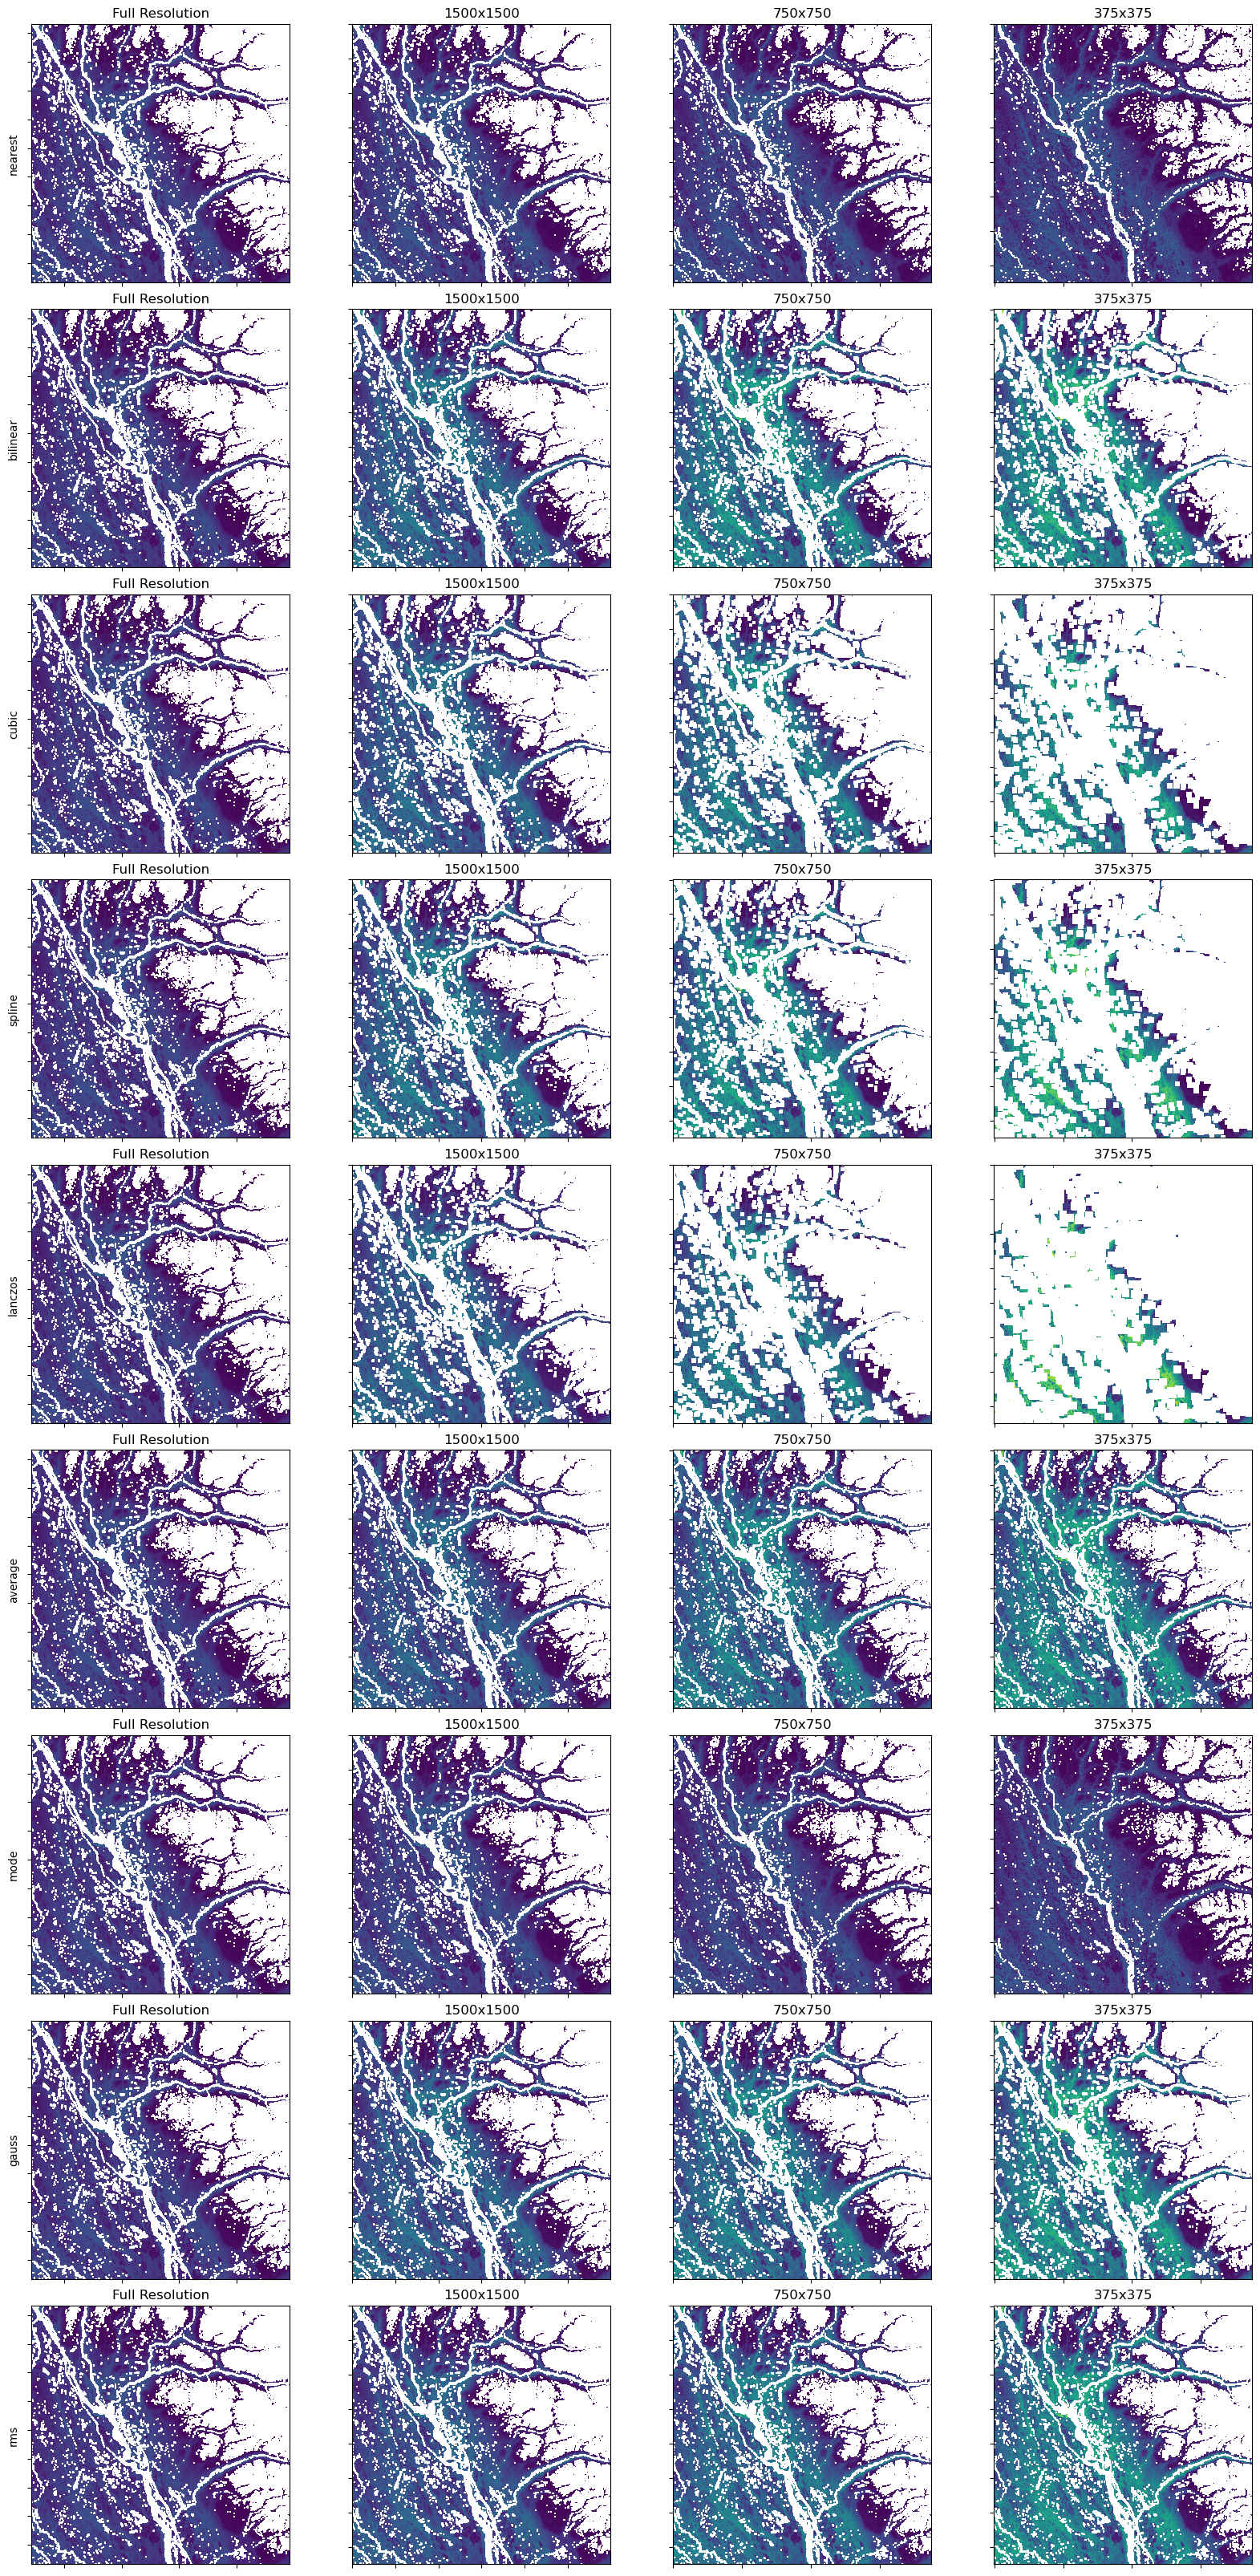

In [12]:
fig, ax_list = plt.subplots(ncols=4, nrows=len(files), figsize=(16,32), constrained_layout=True)
row = 0
for file in files:
    compare_overviews(file, fig, ax_list, row)
    row += 1


## Interpretation

With this particular example, you can see the default method (CUBIC) over-represents the amount of NoData cells as you zoom out (left to right). You can also see how some algorithms hide NoData when zoomed out, and the different methods vary in their level of smoothness.

Depending on what impression you want viewers to get, comparing will help you choose which method to use.